### Тестовое задание для аналитика 🧙🏼

#### Часть 1

Есть два🪑 набора данных:   
- визиты пользователей на сервис
- данные по покупкам 

У каждого визита есть источник, а также устройство, с которого заходил пользователь.

Обозначения в файлах:  
📌**start_dt** — дата старта визита,  
📌**start_ts** — дата и время старта визита,  
📌**end_ts** — дата окончания визита,  
📌**uid** — идентификатор пользователя,  
📌**source_id** — id источника визита,  
📌**device** — устройство,  
📌**buy_ts** — дата и время покупки,  
📌**revenue** — доход в y.e.  

**Необходимо определить**:  
1) Какая когорта пользователей (по месяцу первой покупки) принесла наибольший средний чек на пользователя, какая наименьший.  
2) Какой LTV на каждую когорту пользователей (по месяцу первой покупки)?  

⚠️Просьба написать sql-запросы и визуализировать данные с помощью любого инструмента.⚠️  

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

**Решение**  

Попробуем изучить предложенные данные. 

In [2]:
with open('purchases', 'r') as file:
    for _ in range(10):
        line = file.readline()
        print(line)

buy_ts	uid	revenue

23.07.2016 19:13:54	3492372810	1,47

06.11.2016 02:48:27	1564753091	1,11

31.01.2017 20:32:42	1385616391	16,8

11.01.2017 10:52:11	2636761148	11

25.11.2016 18:57:09	2945629974	4,89

16.09.2016 16:09:58	3761521720	9,17

16.12.2016 11:40:20	2085565076	1,83

17.04.2017 14:33:08	3241481847	2,44

06.02.2017 15:56:25	4178371305	4,89



На входе датасет из 3 столбцов, дата покупки, айди пользователя и доход.  
Неплохо, но наша задача написать sql запрос.  
Для этого поднимем базу данных и зальем туда информацию по покупкам.

In [3]:
import sqlite3

# Создаем соединение с базой данных
conn = sqlite3.connect('test_task.db')
cursor = conn.cursor()

# Создаем таблицу в базе данных
cursor.execute('''
    CREATE TABLE IF NOT EXISTS purchases (
        id INTEGER PRIMARY KEY,
        buy_ts TEXT,
        uid INTEGER,
        revenue REAL
    )
''')

# Читаем содержимое файла
with open('purchases', 'r') as file:
    next(file)  # Пропускаем первую строку (с заголовками столбцов)
    for line in file:
        data = line.strip().split('\t')  # Предполагаем, что данные разделены символом табуляции
        buy_ts = data[0]
        uid = data[1]
        revenue = float(data[2].replace(',', '.'))

        # Вставляем данные из файла в базу данных
        cursor.execute('INSERT INTO purchases (buy_ts, uid, revenue) VALUES (?, ?, ?)', (buy_ts, uid, revenue))

conn.commit()

# Закрываем соединение
conn.close()

print('Данные успешно загружены в базу данных.')

Данные успешно загружены в базу данных.


In [4]:
# напишем функцию для обработки наших селектов
def select(sql):
  return pd.read_sql(sql,conn)

In [5]:
conn = sqlite3.connect('test_task.db')
cursor = conn.cursor()
sql = ''' select count(1) as cnt, sum(revenue) as rev from  purchases'''
select(sql)

,cnt,rev
0,302864,1483296.32


Итого на вход 75к строк с общим доходом на 370к.  
Перейдем ко второму датасету.

In [6]:
with open('visits', 'r') as file:
    for _ in range(10):
        line = file.readline()
        print(line)

device	end_ts	source_id	start_dt	start_ts	uid

desktop	2016-11-30T11:04:17Z	2	2016-11-30	2016-11-30T10:53:49Z	3758486201

desktop	2016-11-10T23:16:57Z	4	2016-11-10	2016-11-10T23:08:04Z	2933941628

desktop	2016-10-19T18:51:56Z	1	2016-10-19	2016-10-19T18:48:16Z	1465872791

desktop	2017-01-12T20:51:55Z	9	2017-01-12	2017-01-12T20:50:10Z	2751875787

touch	2016-07-23T19:17:19Z	4	2016-07-23	2016-07-23T19:10:57Z	3492372810

desktop	2016-09-16T09:36:42Z	5	2016-09-16	2016-09-16T09:34:40Z	1922647915

desktop	2017-01-29T14:27:21Z	4	2017-01-29	2017-01-29T14:06:31Z	3085935958

desktop	2017-02-08T15:53:26Z	3	2017-02-08	2017-02-08T15:42:39Z	1064958609

desktop	2016-11-06T02:54:57Z	5	2016-11-06	2016-11-06T02:38:06Z	1564753091



Тут информации побольше. Есть канал продаж. Есть тип девайса.  

Создадим вторую таблицу в нашей тестовой базе данных и зальем туда эти данные.

In [7]:
conn = sqlite3.connect('test_task.db')
cursor = conn.cursor()


cursor.execute('''
    CREATE TABLE IF NOT EXISTS visits (
        id INTEGER PRIMARY KEY,
        device TEXT,
        end_ts TEXT,
        source_id INTEGER,
        start_dt TEXT,
        start_ts TEXT,
        uid INTEGER
    )
''')

# Читаем все строки из файла
with open('visits', 'r') as file:
    next(file)  # Пропускаем первую строку (с заголовками столбцов)
    for line in file:
        data = line.strip().split('\t')  # Предполагаем, что данные разделены символом табуляции
        device = data[0]
        end_ts = data[1]
        source_id = int(data[2])
        start_dt = data[3]
        start_ts = data[4]
        uid = int(data[5])

        # Вставляем данные из файла в базу данных
        cursor.execute('INSERT INTO visits (device, end_ts, source_id, start_dt, start_ts, uid) VALUES (?, ?, ?, ?, ?, ?)',
                       (device, end_ts, source_id, start_dt, start_ts, uid))

conn.commit()
conn.close()
print('Все строки данных успешно загружены в базу данных.')

Все строки данных успешно загружены в базу данных.


In [8]:
conn = sqlite3.connect('test_task.db')
cursor = conn.cursor()
sql = ''' select count(1) as cnt from visits'''
select(sql)

,cnt
0,2162037


Итого 720к строк с визитами.

❓**Какая когорта пользователей (по месяцу первой покупки) принесла наибольший средний чек на пользователя, какая наименьший**❓

Изучим таблицу с покупками.

In [9]:
sql = ''' SELECT *
FROM purchases v
limit 7'''
select(sql)

,id,buy_ts,uid,revenue
0,1,23.07.2016 19:13:54,3492372810,1.47
1,2,06.11.2016 02:48:27,1564753091,1.11
2,3,31.01.2017 20:32:42,1385616391,16.80
3,4,11.01.2017 10:52:11,2636761148,11.00
4,5,25.11.2016 18:57:09,2945629974,4.89
5,6,16.09.2016 16:09:58,3761521720,9.17
6,7,16.12.2016 11:40:20,2085565076,1.83


В таблице перечислены даты покупки и сумма. 
Проверим датасет на наличие аномальных оплат.

In [10]:
sql = ''' SELECT min(revenue) as r1,
max(revenue) as r2
FROM purchases v
'''
select(sql)

,r1,r2
0,0.0,2633.28


Сложно без контекста оценить аномальность максимального значения.  
А вот минимальное значение 0 нам может исказить среднее. Проверим сколько таких строк в датасете.

In [11]:
sql = ''' SELECT count(*)
FROM purchases v
where revenue = 0'''
select(sql)

,count(*)
0,228


57 строк не могут исказить такую большую выборку, но оставлять их в расчетах без понимания причин не имеет смысла. Это может быть как техническая ошибка, так и особенность округления. Учтем данные нюансы в логике оператора WHERE.

Напишем код, который даст ответ про средний чек в когортах.
Сначала определим минимальный месяц для каждого клиента и положим это в CTE.
Потом присоединим к покупкам когорту клиента и сгруппируем по ней данные о среднем чеке.
Не забудем вывести размеры выборок, чтобы визуально оценить стат.значимость.

In [12]:
sql = '''
with first_month as  (select uid, min(substr(buy_ts, 4, 8)) as first_purchase
    from purchases
    where revenue > 0
    group by uid
)
select fp.first_purchase,
count(distinct p.uid) as clients,
avg(p.revenue) AS avg_per_user
from purchases p
left join first_month fp
on fp.uid = p.uid
where revenue > 0
group by fp.first_purchase
order by avg(p.revenue) desc
    
'''
select(sql)

,first_purchase,clients,avg_per_user
0,06.2017,4,10.325000
1,01.2017,5786,7.539724
2,07.2016,2890,5.170645
3,08.2016,2051,4.682625
4,09.2016,3782,4.589301
5,04.2017,3616,4.545037
6,11.2016,5626,4.440598
7,03.2017,5654,4.352285
8,05.2017,4704,4.228634
9,10.2016,6295,4.188306


**Ответ**: лучшей когортой по среднему чеку является июнь 2017 года, но кол-во клиентов не позволяет принимать во внимание 
данный показатель.   

Спускаемся на строчку ниже.  

👼🏻Правильный ответ:👼🏻  
✅ лучшая когорта по среднему чеку это январь 2017 года  
⛔️ худшая  когорта по среднему чеку это июнь 2016 года  

❓**Какой LTV на каждую когорту пользователей (по месяцу первой покупки)?**❓

**LTV (Lifetime Value)** обычно рассчитывается с момента первой покупки пользователя, так как это является более точным показателем дохода, который пользователь приносит бизнесу.

Информации по расходам на рекламу и оттоку у нас нет, поэтому посчитаем по самой простой формуле: общий доход на когорту разделить на количество клиентов.

In [13]:
sql = '''
with first_month as  
(select uid, min(substr(buy_ts, 4, 8)) as first_purchase,
count(revenue) as offer_cnt,
sum(revenue) as rev
    from purchases
    where revenue > 0
    group by uid
)
select first_purchase,
count(distinct uid) as clients,
sum(offer_cnt) as offer_cnt,
round(sum(offer_cnt)/cast(count(distinct uid) as float), 3) as offers_clients,
sum(rev) as rev,
sum(rev)/count(distinct uid) as ltv
from first_month
group by first_purchase

'''
ltable = select(sql)
ltable

,first_purchase,clients,offer_cnt,offers_clients,rev,ltv
0,01.2017,5786,55936,9.667,421742.00,72.890080
1,02.2017,6026,33196,5.509,135911.92,22.554252
2,03.2017,5654,30752,5.439,133841.48,23.671999
3,04.2017,3616,18392,5.086,83592.32,23.117345
4,05.2017,4704,22232,4.726,94011.00,19.985332
5,06.2016,3270,16244,4.968,62579.48,19.137456
6,06.2017,4,16,4.000,165.20,41.300000
7,07.2016,2890,14264,4.936,73754.08,25.520443
8,08.2016,2051,9920,4.837,46451.64,22.648289
9,09.2016,3782,18300,4.839,83984.20,22.206293


А тут мы видим чем обусловлено высокий средний чек для клиентов из когорты  01.2017.
Добавим визуализации.

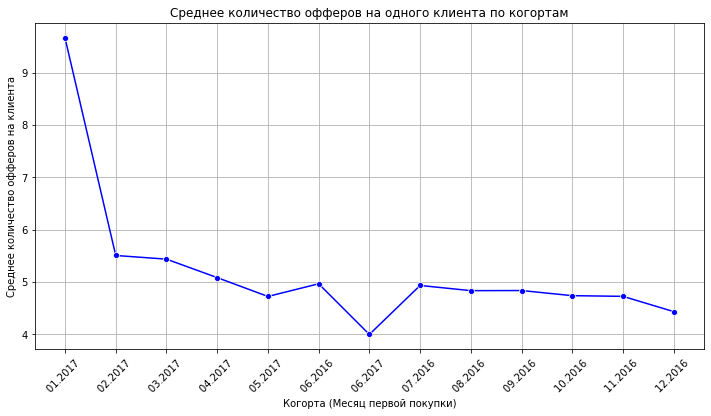

In [15]:
ltab = ltable[['first_purchase', 'offers_clients']]
df = ltab.sort_values(by='first_purchase')
plt.figure(figsize=(12, 6))
sns.lineplot(x='first_purchase', y='offers_clients', data=df, marker='o', color='b')
plt.title('Среднее количество офферов на одного клиента по когортам')
plt.xlabel('Когорта (Месяц первой покупки)')
plt.ylabel('Среднее количество офферов на клиента')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Да, клиенты зашедшие в компанию 01.2017 имеет повышенный спрос на финансовые услуги и покупают в среднем в 2 раза больше, чем клиенты из остальных когорт.  
Это может быть обусловлено какой-то маркетинговой акцией в этот месяц, которая гарантировала клиентам спец.условия по дальнейшим покупкам.  

**Сделаем визуализацию для LTV**

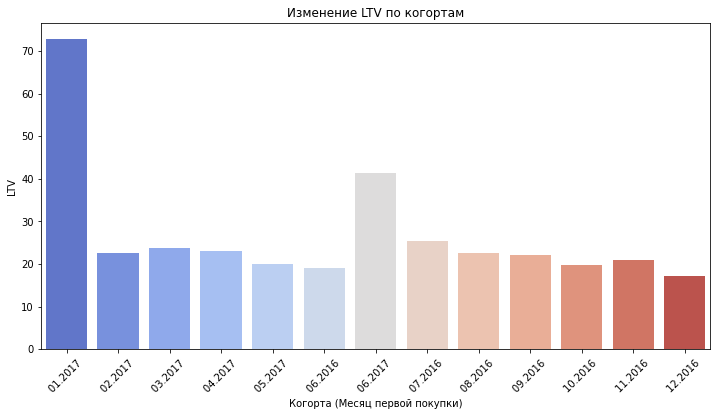

In [16]:
ltab = ltable[['first_purchase', 'ltv']]
plt.figure(figsize=(12, 6))
sns.barplot(x='first_purchase', y='ltv', data=ltab, palette='coolwarm')
plt.xlabel('Когорта (Месяц первой покупки)')
plt.ylabel('LTV')
plt.title('Изменение LTV по когортам')
plt.xticks(rotation=45)
plt.show()

LTV так же отражает аномальную ценность клиентов по сравнению с остальными когортами.

Все еще смущает когорта 06.2017. Изучим что там лежит

In [33]:
sql = '''
with first_month as  
(select uid, min(substr(buy_ts, 4, 8)) as first_purchase
    from purchases
    where revenue > 0
    group by uid
)
select p.*, fp. first_purchase
from purchases p
left join first_month fp
on fp.uid = p.uid
where first_purchase like '%06.2017%'

'''
ltable = select(sql)
ltable

,id,buy_ts,uid,revenue,first_purchase
0,19573,01.06.2017 00:07:12,3150804798,4.64,06.2017
1,24000,01.06.2017 00:01:22,1865813875,8.80,06.2017
2,34784,01.06.2017 00:03:30,2225285757,3.42,06.2017
3,56780,01.06.2017 00:02:38,285702455,24.44,06.2017
4,95289,01.06.2017 00:07:12,3150804798,4.64,06.2017
5,99716,01.06.2017 00:01:22,1865813875,8.80,06.2017
6,110500,01.06.2017 00:03:30,2225285757,3.42,06.2017
7,132496,01.06.2017 00:02:38,285702455,24.44,06.2017
8,171005,01.06.2017 00:07:12,3150804798,4.64,06.2017
9,175432,01.06.2017 00:01:22,1865813875,8.80,06.2017


Теперь стало понятнее. В выборку попал неполный месяц. Всего 4 клиента самого начала - июня 2017. Тут изучать особо нечего, выборка не релевантна

**Вывод**: рассчитано LTV на каждого клиента в рамках когорт по месяцу первой покупки.  
Рекордными показателями по LTV, cnt_offers, revenue может похвастаться когорта 01.2017.  
У нас нет понимания контекста этого месяца, но возможно какие-то ответы сможет дать таблица с визитами. Проверим.

In [52]:
sql = '''
select substr(start_dt, 1, 7) as dat,
count(id) as cnt,
count(distinct uid) as clients,
count(distinct uid)*1.0/count(id)*1.0  visit_per_client
from visits
group by dat
'''
ltable = select(sql)
ltable 

,dat,cnt,clients,visit_per_client
0,2016-06,98805,23926,0.242154
1,2016-07,106227,25352,0.238659
2,2016-08,86409,21054,0.243655
3,2016-09,144984,34114,0.235295
4,2016-10,227619,52736,0.231685
5,2016-11,265737,57289,0.215585
6,2016-12,251460,55090,0.219081
7,2017-01,222411,51277,0.230551
8,2017-02,223794,51085,0.228268
9,2017-03,214917,48668,0.226450


Нет, когорта 01.2017 не является такой же аномальной как по количеству визитов, так и по метрике кол-во визитов на одного клиента.

#### Часть 2

Аналитик заходит в отчетность и видит воронку 

⚠️**Необходимо определить**:⚠️
  
Какой шаг воронки 17.09.2023 больше всего повлиял на снижение количества целевых действий (оформление договора)? Почему?

**Воронка**

🔔**Решение**🔔  
В рамках данной задачи нет доп.условий по путям ее решения(например, использование SQL).  
Для решения задачи используем волшебство Питона🐍.

В рамках задачи отчетность дана текстом. С этим не очень удобно работать, конвертируем её в привычный датафрейм. 
Для этого:  
1. Создадим файл эксель
2. Скопируем в него данные по воронке
3. Прочитаем его с помощью pandas

In [18]:
df = pd.read_excel('task2.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datas               8 non-null      datetime64[ns]
 1   visits              8 non-null      int64         
 2   create_application  8 non-null      int64         
 3   application         8 non-null      int64         
 4   offer               8 non-null      int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 448.0 bytes


**Выведем динамику визитов по дням**

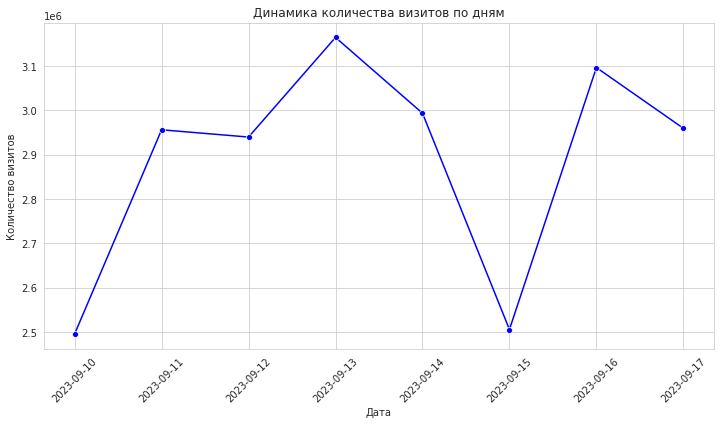

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='datas', y='visits', data=df[['datas', 'visits']], marker='o', color='b')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.title('Динамика количества визитов по дням')
plt.xticks(rotation=45)
plt.show()

Даже при первом касании в глаза бросается проседание 17 сентября.  
Заглянем в календарь - 17 сентября 2023 это воскресенье.  
**Гипотеза:** по воскресеньям люди не демонстрируют высокий спрос на фин.услуги.  
Поэтому проседание можно обьяснить особенностью выходного дня.  
Но мы попробуем копнуть чуть глубже и определить тренды.

**Построим воронку** от количества визитов

In [20]:
funnel_df = df.copy()
for col in df.columns[1:]:
    funnel_df[col] = (df[col] / df['visits']) * 100
funnel_df

,datas,visits,create_application,application,offer
0,2023-09-10,100.0,0.423387,0.243847,0.093957
1,2023-09-11,100.0,0.321603,0.177409,0.067311
2,2023-09-12,100.0,0.359687,0.210200,0.080883
3,2023-09-13,100.0,0.347162,0.188385,0.069799
4,2023-09-14,100.0,0.330810,0.183742,0.072582
5,2023-09-15,100.0,0.346109,0.199493,0.077658
6,2023-09-16,100.0,0.326912,0.175597,0.068909
7,2023-09-17,100.0,0.249744,0.120682,0.037232


Любопытно, 10 сентября это тоже воскресенье. При этом, в этот день лучшая конверсия в заявку, в заполненное заявление и в офер.
Гипотеза про выходной не состоятельна. **Отвергаем её**.

А теперь построим воронку от предыдущего шага.

In [21]:
conversion_df = df.copy()
conversion_df['create_cr'] = conversion_df['create_application'] / conversion_df['visits'] * 10000
conversion_df['app_cr'] = conversion_df['application'] / conversion_df['create_application'] * 100
conversion_df['offer_cr'] = conversion_df['offer'] / conversion_df['application'] * 100
conversion_df = conversion_df[['datas', 'create_cr', 'app_cr', 'offer_cr']]
conversion_df 

,datas,create_cr,app_cr,offer_cr
0,2023-09-10,42.338689,57.594398,38.531055
1,2023-09-11,32.160323,55.164072,37.940896
2,2023-09-12,35.968666,58.439716,38.478964
3,2023-09-13,34.716221,54.264130,37.051325
4,2023-09-14,33.080995,55.543215,39.501909
5,2023-09-15,34.610900,57.638649,38.927786
6,2023-09-16,32.691209,53.713947,39.242369
7,2023-09-17,24.974357,48.322511,30.851064


Тут мы видим значительное проседание на всех этапах именно 17 сентября. Вероятно это обусловлено внешними факторами, которые мы пока не учитываем.

**Изучим и визуализиурем конверсию в следующий шаг для каждого шага**

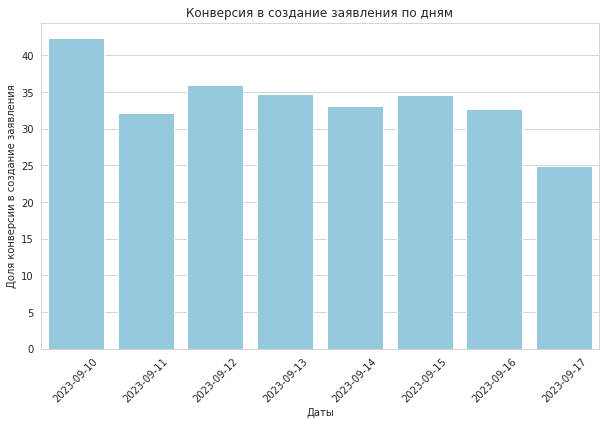

In [22]:
conversion_df['datas'] = pd.to_datetime(conversion_df['datas'])
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_df['datas'].dt.strftime('%Y-%m-%d'), y='create_cr', data=conversion_df, color='skyblue')
plt.xlabel('Даты')
plt.ylabel('Доля конверсии в создание заявления')
plt.title('Конверсия в создание заявления по дням')
plt.xticks(rotation=45) 
plt.show()

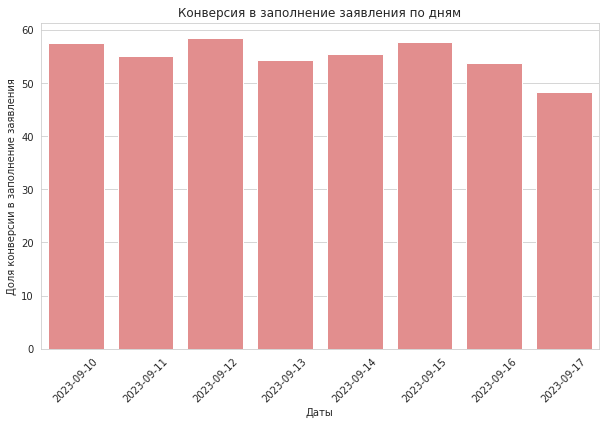

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_df['datas'].dt.strftime('%Y-%m-%d'), y='app_cr', data=conversion_df, color='lightcoral')
plt.xlabel('Даты')
plt.ylabel('Доля конверсии в заполнение заявления')
plt.title('Конверсия в заполнение заявления по дням')
plt.xticks(rotation=45) 
plt.show()

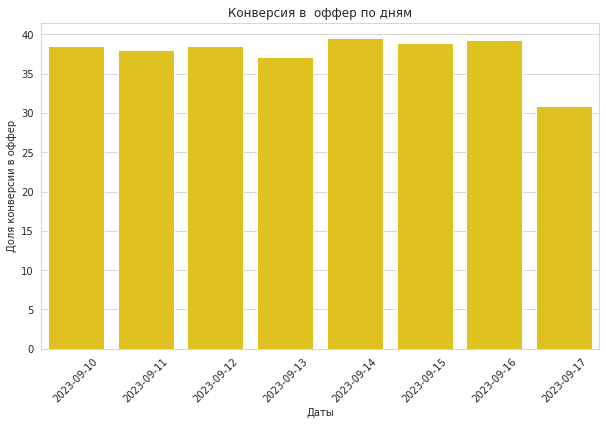

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_df['datas'].dt.strftime('%Y-%m-%d'), y='offer_cr', data=conversion_df, color='gold')
plt.xlabel('Даты')
plt.ylabel('Доля конверсии в оффер')
plt.title('Конверсия в  оффер по дням')
plt.xticks(rotation=45) 
plt.show()

**Вывод**: в рамках недели конверсия в следующий шаг колебается, но колебания в рамках логически обьяснимого.  
А вот 17 сентября происходит значительное изменение метрики конверсий на каждом шаге.
1. Разделим наш датафрейм на 2, в первом будет 7дневный период нормы, во втором аномальное 17 сентября.
2. Сравним средние показатели конверсии нормы с аномальным днем.
3. Выясним на каком шаге происходят наибольшие потери клиентов.

In [53]:
good_days = conversion_df.query('datas != "2023-09-17" ')
bad_day = conversion_df.query('datas == "2023-09-17" ')
print(f'Средняя конверcия в создание заявки: норма {round(good_days["create_cr"].mean(), 1)} 17 сентября {round(bad_day["create_cr"].values[0], 0)}')
print(f'Снижение конверсии на первом шаге {round(bad_day["create_cr"].values[0]/good_days["create_cr"].mean()*100-100, 2) }%')

Средняя конверcия в создание заявки: норма 35.1 17 сентября 25.0
Снижение конверсии на первом шаге -28.81%


In [26]:
print(f'Средняя конверcия в заполнение заявки: норма {round(good_days["app_cr"].mean(), 1)} 17 сентября {round(bad_day["app_cr"].values[0], 0)}')
print(f'Снижение конверсии на втором шаге {round(bad_day["app_cr"].values[0]/good_days["app_cr"].mean()*100-100, 2) }%')

Средняя конверcия в заполнение заявки: норма 56.1 17 сентября 48.0
Снижение конверсии на втором шаге -13.79%


In [27]:
print(f'Средняя конверcия в оффер: норма {round(good_days["offer_cr"].mean(), 1)} 17 сентября {round(bad_day["offer_cr"].values[0], 0)}')
print(f'Снижение конверсии на третьем шаге {round(bad_day["offer_cr"].values[0]/good_days["offer_cr"].mean()*100-100, 2) }%')

Средняя конверcия в оффер: норма 38.5 17 сентября 31.0
Снижение конверсии на третьем шаге -19.92%


✅**Вывод**: наибольшая потеря конверсии происходит на первом шаге. То есть значительно страдает конверсия из визитов в заполнение заявления.

С чем это может быть связано?  
**Две гипотезы:** баги на странице заполнения заявки или внешние факторы.  
**Первую гипотезу** проверить нет возможности, так как вводные по техн.ограничениям не указаны. Оставим гипотезу в виртуальном возможном статусе.  
**Вторая**: внешние факторы. На падение конверсии может повлиять ухудшение условий по продукту. Ухудшение условий часто связано с повышением ключевой ставки.

[15 сентября ЦБ РФ повысил ключевую ставку до 13%](https://cbr.ru/press/pr/?file=15092023_133000Key.htm#:~:text=%D0%BF.%2C%20%D0%B4%D0%BE%2013%2C00%25%20%D0%B3%D0%BE%D0%B4%D0%BE%D0%B2%D1%8B%D1%85,-15%20%D1%81%D0%B5%D0%BD%D1%82%D1%8F%D0%B1%D1%80%D1%8F%202023&text=%D0%A1%D0%BE%D0%B2%D0%B5%D1%82%20%D0%B4%D0%B8%D1%80%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2%20%D0%91%D0%B0%D0%BD%D0%BA%D0%B0%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%2015,%D0%B4%D0%BE%2013%2C00%25%20%D0%B3%D0%BE%D0%B4%D0%BE%D0%B2%D1%8B%D1%85.)

Тогда почему падение не произошло 16 сентября? Вероятно какое-то время понадобилось на изменение условий по продукту в диджитал-каналах. 
Хронология:  
📅 **15 сентября** повышение ключ.ставки  
📅 **16 сенятбря** рефакторинг условий по продукт и выкат их в прод с 17 сентября  
📅 **17 сентября** люди приходят за деньгами, но видят, что условия ухудшились. Не всем это подходит.  

✅**Мой ответ**: значительное падение конверсии из визита в заявку связано с ухудшением кредитных условий, которые вызваны  повышением ключевой ставки.

#### Часть 3

В таблице test_tbl содержатся неповторяющиеся числа от 1 до N, при этом строк в таблице N-1, требуется вывести пропущенное число при помощи скрипта SQL

**Решение**  
Для этого задания создадим 3 тестовые таблицы, на которых будем проверять наше решение.

In [57]:
conn = sqlite3.connect('test_task.db')
cursor = conn.cursor()

cursor.execute('drop TABLE test_tbl1')
cursor.execute('drop TABLE test_tbl2')
cursor.execute('drop TABLE test_tbl3')
# Создаем и заполняем таблицу test_tbl1 (1 до 10, пропущено 7)
cursor.execute('CREATE TABLE IF NOT EXISTS test_tbl1 (number INTEGER)')
cursor.executemany('INSERT INTO test_tbl1 (number) VALUES (?)', [(i,) for i in range(1, 11) if i != 7])

# Создаем и заполняем таблицу test_tbl2 (1 до 30, пропущено 21)
cursor.execute('CREATE TABLE IF NOT EXISTS test_tbl2 (number INTEGER)')
cursor.executemany('INSERT INTO test_tbl2 (number) VALUES (?)', [(i,) for i in range(1, 31) if i != 21])

# Создаем и заполняем таблицу test_tbl3 (1 до 99, пропущено 89)
cursor.execute('CREATE TABLE IF NOT EXISTS test_tbl3 (number INTEGER)')
cursor.executemany('INSERT INTO test_tbl3 (number) VALUES (?)', [(i,) for i in range(1, 100) if i != 89])
conn.commit()

print('Тестовые таблицы успешно созданы и заполнены.')

Тестовые таблицы успешно созданы и заполнены.


In [58]:
sql = ''' select * from test_tbl1'''
select(sql)

,number
0,1
1,2
2,3
3,4
4,5
5,6
6,8
7,9
8,10


Для решения это задачи воспользуемся CTE:
1. Создаем таблицу, в которой будут все числа в заданном диапазоне без учета пропусков.
2. Приджойним к ней изначальную таблицу.
3. В фильтре WHERE укажем, что в результате должны остаться только те числа, которые не нашли себе пару при джоине.

**Тест 1** 

test_tbl1 (1 до 10, пропущено 7)

In [59]:
sql = ''' with RecursiveCTE as (
    select 1 AS number
    union all
    select number + 1
    from RecursiveCTE
    where number < (select count(1) from test_tbl1)
)
select r.number
from RecursiveCTE r
left join test_tbl1 t ON r.number = t.number
where t.number is null
'''
select(sql)

,number
0,7


**Тест 2** 

test_tbl2 (1 до 30, пропущено 21)

In [60]:
sql = ''' with RecursiveCTE as (
    select 1 AS number
    union all
    select number + 1
    from RecursiveCTE
    where number < (select count(1) from test_tbl2)
)
select r.number
from RecursiveCTE r
left join test_tbl2 t ON r.number = t.number
where t.number is null
'''
select(sql)

,number
0,21


**Тест 3** 

test_tbl3 (1 до 99, пропущено 89)

In [61]:
sql = ''' with RecursiveCTE as (
    select 1 AS number
    union all
    select number + 1
    from RecursiveCTE
    where number < (select count(1) from test_tbl3)
)
select r.number
from RecursiveCTE r
left join test_tbl3 t ON r.number = t.number
where t.number is null
'''
select(sql)

,number
0,89


📍 **Итог**  

✅**3 из 3** тестов подтвердили корректность применимости данного решения.  
Пропущенные значения **найдены**.  
Скрипт не перегружен и легко читаем.

♻️**Возможная доработка**  
при необходимости, можно вынести название таблицы в отдельную переменную, чтобы указывать её не 2 раза(как сейчас) в скрипте, а 1 раз до самого скрипта.